# Milestone 2

By December 15 you shall have implemented multiple baseline solutions to
your main text classification task. These should include both deep learning (DL) based methods
such as those introduced in Weeks 5-6 but also non-DL models such as those shown in Week 3.
Baselines can also include simple rule-based methods (e.g. keyword matching or regular expres-
sions). Each baseline should be evaluated both quantitatively and qualitatively, more details will
be provided in the lecture on text classification (Week 3)


## Load modules

In [10]:
#Functions
from utils import extract_original_text, extract_preprocessed_text, load_conllu_data

#Global
import os
import pandas as pd
import conllu
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#Sickit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_fscore_support
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
import joblib
import shap

#NN, Transformers
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import transformers
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, AutoTokenizer
from transformers import BertForSequenceClassification, AutoModelForSequenceClassification, RobertaForSequenceClassification

C:\Users\Ugo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'transformers'

## Load files

In [2]:
# Load the entire .conllu file into a Python variable
conllu_data = []
with open('Data/preprocessed_dataset.conllu', 'r', encoding='utf-8') as f:
    for line in f:
        conllu_data.append(line.strip())

# Display a sample of the loaded data (e.g., first 5 lines)
print("\n".join(conllu_data[:10]))

anns = pd.read_table('Data/annotations.txt', header=None)

# sent_id = 0_0
# text = And this Conservative strategy has produced the angry and desperate wing-nuts like the fellow who called reporters 'lying pieces of Sh*t' this week.
1	And	and	CCONJ	CC	_	None	None	_	_
2	this	this	DET	DT	Number=Sing|PronType=Dem	None	None	_	_
3	Conservative	Conservative	ADJ	JJ	Degree=Pos	None	None	_	_
4	strategy	strategy	NOUN	NN	Number=Sing	None	None	_	_
5	has	have	AUX	VBZ	Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin	None	None	_	_
6	produced	produce	VERB	VBN	Tense=Past|VerbForm=Part	None	None	_	_
7	the	the	DET	DT	Definite=Def|PronType=Art	None	None	_	_
8	angry	angry	ADJ	JJ	Degree=Pos	None	None	_	_


Format of sent_id : X_Y

Where X is the id of the comment, while Y is the id of the sentence.

Example : 2_3 means it's comment with id 2 and its 3rd sentence.

## Load both original and preprocessed texts

In [6]:
file_path = 'Data/preprocessed_dataset.conllu'
original_list = extract_original_text(file_path)
original_list[:3]

["And this Conservative strategy has produced the angry and desperate wing-nuts like the fellow who called reporters 'lying pieces of Sh*t' this week. The fortunate thing is that reporters were able to report it and broadcast it - which may shake up a few folks who recognize a bit of themselves somewhere in there and do some reflecting. I live in hope.",
 "I commend Harper for holding the debates outside of a left-wing forum as this will help prevent the left from manipulating the debates to try to make Harper look bad. Indeed, we’ll finally have some fair debates. Trudeau is a coward and the only one who’s opposing this as he’s terrified about losing left-wing protection during the debates if the debates are held elsewhere. If Trudeau doesn’t have Chretien or Martin speaking for him or isn't currently in training to learn how to handle himself in a debate, he has May attending the debates to hold his little hand. If Trudeau can’t speak for himself or handle debates, how does he expect

In [7]:
preprocessed_list = extract_preprocessed_text(file_path)
preprocessed_list[:3]

["and this conservative strategy have produce the angry and desperate wing - nut like the fellow who call reporter 's lying piece of sh*tember ' this week . the fortunate thing be that reporter be able to report it and broadcast it - which may shake up a few folk who recognize a bit of themselves somewhere in there and do some reflect . i live in hope .",
 'i commend harper for hold the debate outside of a left - wing forum as this will help prevent the left from manipulate the debate to try to make harper look bad . indeed , we will finally have some fair debate . trudeau be a coward and the only one who be oppose this as he be terrified about lose left - wing protection during the debate if the debate be hold elsewhere . if trudeau do not have chretien or martin speak for he or be not currently in training to learn how to handle himself in a debate , he have may attend the debate to hold his little hand . if trudeau can not speak for himself or handle debate , how do he expect to run

# Naive Bayesian Classifier

$P(C|X) = \frac{P(X|C) \cdot P(C)}{P(X)}$

Where:

- $P(C|X)$ is the posterior probability of class $C$ given features $X$
- $P(X|C)$ is the likelihood of features $X$ given class $C$
- $P(C)$ is the prior probability of class $C$
- $P(X)$ is the total probability of features $X$


### For original text

1. Gather Data (already done)
2. Vectorization (using TF-IDF)
3. Splitting into training and testing data
4. Training the Naive Bayes classifier
5. Evaluate the model

In [13]:
#2 Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(original_list)
y = anns

#3 Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#4 Training the Naive Bayes classifier
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}  # Adjust the range as needed
model = MultinomialNB()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train.values.ravel())

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

#5 Evaluate the model
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best alpha: 0.1
Best cross-validation accuracy: 0.6761
Accuracy: 0.6875

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.48      0.58      1086
           1       0.67      0.86      0.75      1314

    accuracy                           0.69      2400
   macro avg       0.70      0.67      0.67      2400
weighted avg       0.70      0.69      0.67      2400



In [14]:
joblib.dump(best_model, "models/original_naive_bayes_model.pkl")

# Load the saved model
best_model_loaded = joblib.load("models/original_naive_bayes_model.pkl")

# Use the loaded model for predictions
y_pred_loaded = best_model_loaded.predict(X_test)
print("Accuracy (using loaded model):", accuracy_score(y_test, y_pred_loaded))

Accuracy (using loaded model): 0.6875


### For preprocessed text

In [15]:
#2 Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_list)
y = anns

#3 Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#4 Training the Naive Bayes classifier
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}  # Adjust the range as needed
model = MultinomialNB()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train.values.ravel())

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

#5 Evaluate the model
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best alpha: 0.1
Best cross-validation accuracy: 0.6760
Accuracy: 0.6808333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.47      0.57      1086
           1       0.66      0.85      0.75      1314

    accuracy                           0.68      2400
   macro avg       0.69      0.66      0.66      2400
weighted avg       0.69      0.68      0.67      2400



In [22]:
joblib.dump(best_model, "models/preprocessed_naive_bayes_model.pkl")

# Load the saved model
best_model_loaded = joblib.load("models/preprocessed_naive_bayes_model.pkl")

# Use the loaded model for predictions
y_pred_loaded = best_model_loaded.predict(X_test)
print("Accuracy (using loaded model):", accuracy_score(y_test, y_pred_loaded))

Accuracy (using loaded model): 0.6808333333333333


# Second experiment: Use Feature based models 

Idea: Use the features from the CONLL-U format to feed Machine Learning models (SVM, Random Forest, KNN and else) in order to classify the text

1. Extraction of the features:
    - number of tokens
    - average word length
    - number of sentences
    - number of noun, verb, adjective, adverb, pronoun, conjunction and determiner
2. Splitting into training and testing data

In [3]:
file_path = 'Data/preprocessed_dataset.conllu'
features_conllu = load_conllu_data(file_path)
X = features_conllu.drop(['comment_id'], axis=1)
y = anns 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3. Training the models using different parameters
    - K-Nearest Neighbor
    - Random Forest
    - Logisitc Regression
4. Evaluating the best models

In [4]:
# Define hyperparameter grids
param_grids = {
    'knn': {
        'n_neighbors': [3, 5, 10, 15,20,50,100],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'rf': {
        'n_estimators': [10,25, 50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'logisticregression': {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter':[1000]
    }
}

# Train and tune models
models = {
    'knn': KNeighborsClassifier(),
    'rf': RandomForestClassifier(random_state=42),
    'logisticregression': LogisticRegression()
}

best_models = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name.lower()], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train.values.ravel())
    
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    print(f"\n{model_name} Classification Report:\n", classification_report(y_test, y_pred))

    #Save the models
    for model_name, best_model in best_models.items():
        filename = f"models/{model_name}_model.pkl"
        joblib.dump(best_model, filename)
        print(f"{model_name} model saved successfully as {filename}!")


Training knn...
Best Parameters for knn: {'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'uniform'}

knn Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      1086
           1       0.91      0.92      0.92      1314

    accuracy                           0.91      2400
   macro avg       0.91      0.91      0.91      2400
weighted avg       0.91      0.91      0.91      2400

knn model saved successfully as models/knn_model.pkl!

Training rf...
Best Parameters for rf: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}

rf Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      1086
           1       0.93      0.93      0.93      1314

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400

knn model saved successful

## Model explainability

One way to give more explainability to our model is to use SHAP (SHapley Additive exPlanations) values. They quantify how much each feature contributes to a model's prediction for a specific instance, compared to a baseline prediction (typically the average model output).

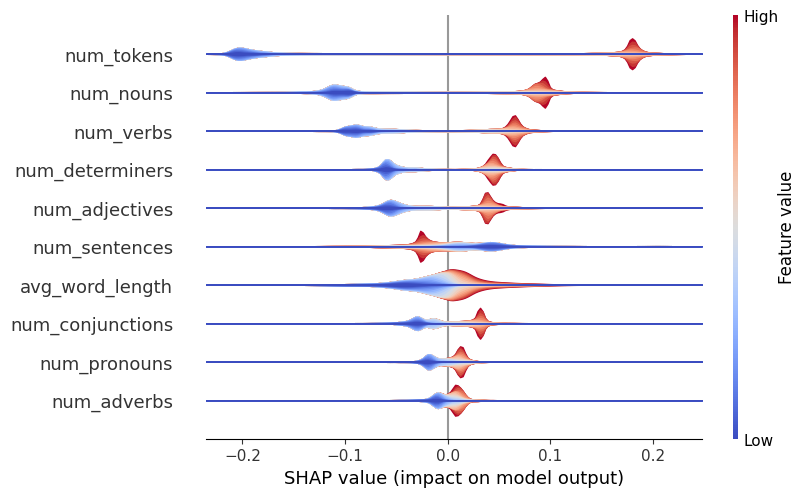

In [31]:
# Create a SHAP Tree Explainer
explainer = shap.TreeExplainer(joblib.load("models/rf_model.pkl"))
shap_values = explainer.shap_values(X_test)
shap.plots.violin(shap_values[:, :, 1], X_test, plot_type="layered_violin")

SHAP values are really intersting what helps our model makes decision towards a class or another, here we learn different things: 
- The number of tokens, nouns and verbs are the features that helps the most our Random Forest
- All of the features, if they have large values (such as a lot of nouns, a lot of verbs) will increase the likelihood in predicting class 1: The Constructive comments
    - One is the opposite, the more sentence there is in a comment, the more likely it will be predicted as Not-Constructive, but the SHAP value is still really low
- Conjunctions, Pronouns and adverbs seems to not play a really big role in the decision taking part of our model

## Qualitative analysis of misclassified comments

The analysis is done on the best behaving feature based model, the Random Forest.

In [9]:
# Retain 'comment_id' for reference
X = features_conllu.drop(['comment_id'], axis=1)
comment_ids = features_conllu['comment_id']

# Split data, retaining comment IDs in the test set
X_train, X_test, y_train, y_test, comment_ids_train, comment_ids_test = train_test_split(
    X, y, comment_ids, test_size=0.2, random_state=42)

# Retrain the best RF model with specified parameters
best_rf = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=50, random_state=42)
best_rf.fit(X_train, y_train.values.ravel())

# Predict on the test set
y_pred = best_rf.predict(X_test)
y_test_array = y_test.values.ravel()
# Identify misclassified indices
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test_array, y_pred)) if true != pred]

# Group misclassified samples by true class
misclassified_by_category = {0: [], 1: []}

for idx in misclassified_indices:
    true_class = y_test_array[idx]
    if true_class in misclassified_by_category:
        misclassified_by_category[true_class].append(comment_ids_test.iloc[idx])

# Print up to 3 misclassified comment IDs for each category
print("Misclassified examples:\n")
for category, comment_ids in misclassified_by_category.items():
    category_name = "constructive" if category == 0 else "not constructive"
    print(f"Category '{category_name}' misclassified as being the opposite:")
    for i, comment_id in enumerate(comment_ids[:3]):
        print(f"- {original_list[int(comment_id)]}\n")
    print()

Misclassified examples:

Category 'constructive' misclassified as being the opposite:
- Trump is irrelevant. The US citizenry needs to clean out the corrupt government as required every several generations. It would have been Perot or Buchanan at another time. Get rid of Trump, and there will be a different name with the same agenda. And the media and establishment will oppose him or her too.

- Until the Globe editorial board can explain why they endorsed the Harper government time and time again and at the same they are reporting on the corruption and lies and scams. These editorials just look foolish to me. Now their a problem with the Harper government?

- '........... that small symbolic acts have great power, ..........'. Yeah, symbology like the fact that some of the strongest proponents for massive lifestyle change just happen to be amongst the biggest carbon gluttons on the planet. You listening Dave?


Category 'not constructive' misclassified as being the opposite:
- Margare

## Takeways

As of Cambridge Dictionary, the definition of 'constructive' is the following: 
- If advice, criticism, or actions are constructive, they are useful and intended to help or improve something

Some synonyms are: useful, helpful, valuable
Saying if a sentence, or a text, is constructive, is in some case prone to subjectivity. As our comments were annotated by crowdworkers, it's possible that another one might argue a comment is or isn't constructive. In these misclassified examples, here are the thoughts: 

### Category 'constructive' misclassified as being the opposite:
- comment 1: The writer uses example in its comment to prove his point, however, the comment seem to show quite a defiance, I could see this as being classified as one or another
- comment 2: This comment talks about a situation on why a editorial board endorsed someone, and it seems constructive to ask why if the same editorial was reporting corruption scandal. It doesn't have a lot of adjective but mostly simple sentences, maybe a reason why the model chose to classify as not constructive
- comment 3: The writer seemed quite angry in its comment and I'm not sure how it contributed constructively to a discussion, it asks a valid question but I would doubt it adds anything positive, I would have classified that as non constructive (like our model)

### Category 'not constructive' misclassified as being the opposite:
- comment 1: It's a well written comment (in english) but doesn't bring anything constructive, adjectives are used but not to bring any real value to the comment
- comment 2: I personally think this comment could (or should) be considered as constructive, it's a reply to a column and the writers gives his point of view on it, giving an argument. 
- comment 3: This is a personnal comment but I would not know how to classify it, depending on the topic, it could had some value to a discussion, or be pointless and thus not constructive

After seeing this, I think the main problem is how subjectivity plays a role in reading a comment as constructive or not, as well as lack of context since it would help knowing if the comment is of value in a discussion. Also some comments may be in between the 2 class, hence a regression task could have been better suited (ex: value from 0 to 1, 0.5 being a comment that could be seen as both)

___
# Now Onto Deep Learning solutions!

In [ ]:
# Dataser preprocessed
X = vectorizer.fit_transform(preprocessed_list)
y = anns

# Training data for Deep Learning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define model architecture
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]), # Input layer
    Dropout(0.2),  # Dropout to avoid overfitting
    Dense(64, activation='relu'),  # Intermediate layer
    Dropout(0.2),  # Dropout to avoid overfitting
    Dense(32, activation='relu'),  # Intermediate layer
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

/Users/saitohiraga/Documents/GitHub/NLP-DetecConstComm-project/venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

In [ ]:
# Train the model
nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7007 - loss: 0.5128 - precision: 0.6740 - recall: 0.9226 - val_accuracy: 0.8661 - val_loss: 0.3013 - val_precision: 0.8942 - val_recall: 0.8537
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9620 - loss: 0.1122 - precision: 0.9677 - recall: 0.9616 - val_accuracy: 0.8562 - val_loss: 0.3519 - val_precision: 0.8523 - val_recall: 0.8884
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9895 - loss: 0.0365 - precision: 0.9937 - recall: 0.9871 - val_accuracy: 0.8578 - val_loss: 0.5207 - val_precision: 0.8383 - val_recall: 0.9134
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9984 - loss: 0.0066 - precision: 0.9994 - recall: 0.9976 - val_accuracy: 0.8510 - val_loss: 0.6279 - val_precision: 0.8359 - val_recall: 0.9018
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9995 - loss: 0.0020 - precision: 0.9997 - recall: 0.9995 - val_accuracy: 0.8557 - val_los

In [ ]:
# Evaluate the model
loss, accuracy, precision, recall = nn_model.evaluate(X_test, y_test)

f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.8937 - precision: 0.8629 - recall: 0.8496
Loss: 0.9024
Accuracy: 0.8446
Precision: 0.8673
Recall: 0.8455


# Trying Bert

In [ ]:
# First split: Divide the original data into training+validation and test sets
X_train_val_bert, X_test_bert, y_train_val_bert, y_test_bert = train_test_split(
    original_list, anns, test_size=0.2, random_state=42
)

# Second split: Divide the training+validation set into training and validation sets
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(
    X_train_val_bert, y_train_val_bert, test_size=0.1, random_state=42
)

# Print the sizes of each set
print(f"Training size: {len(X_train_bert)}, Validation size: {len(X_val_bert)}, Test size: {len(X_test_bert)}")

Training size: 8639, Validation size: 960, Test size: 2400


In [ ]:
# Convert labels to tensors
y_train_bert = torch.tensor(y_train_bert.values, dtype=torch.long)
y_val_bert = torch.tensor(y_val_bert.values, dtype=torch.long)
y_test_bert = torch.tensor(y_test_bert.values, dtype=torch.long)

Unlike traditional NLP pipelines, BERT's tokenizer requires no additional preprocessing:

You don’t need to remove stopwords because BERT can handle their contextual importance.
You don’t need to lemmatize or stem because subwords inherently capture morphological variations (e.g., "run" and "running").
Case sensitivity is handled if you're using the case-sensitive version of BERT.
This makes the process simpler and ensures that the model works with raw input text.

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the data
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

train_encodings = tokenize_texts(X_train_bert, tokenizer)
val_encodings = tokenize_texts(X_val_bert, tokenizer)
test_encodings = tokenize_texts(X_test_bert, tokenizer)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

class CommentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx],
        }

# Create datasets
train_dataset = CommentDataset(train_encodings, y_train_bert)
val_dataset = CommentDataset(val_encodings, y_val_bert)
test_dataset = CommentDataset(test_encodings, y_test_bert)

In [ ]:
# Load BERT model for classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


/Users/gerhardkarbeutz/NLP-DetecConstComm-project/venv/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train() 

  0%|          | 0/3240 [00:00<?, ?it/s]

{'loss': 0.7277, 'grad_norm': 4.439280033111572, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 0.7228, 'grad_norm': 8.950873374938965, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 0.6769, 'grad_norm': 3.9286797046661377, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 0.6457, 'grad_norm': 8.793628692626953, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 0.5729, 'grad_norm': 5.118696689605713, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 0.521, 'grad_norm': 9.963205337524414, 'learning_rate': 6e-06, 'epoch': 0.06}
{'loss': 0.5126, 'grad_norm': 7.262749671936035, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.06}
{'loss': 0.4464, 'grad_norm': 18.62522315979004, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.07}
{'loss': 0.4239, 'grad_norm': 7.297521591186523, 'learning_rate': 9e-06, 'epoch': 0.08}
{'loss': 0.3768, 'grad_norm': 9.70535659790039, 'learning_rate': 1e-05, 'epoch': 0.09}
{'loss': 0.3766, 'grad_norm': 8.3395929

  0%|          | 0/60 [00:00<?, ?it/s]

{'eval_loss': 0.23229672014713287, 'eval_runtime': 7.0351, 'eval_samples_per_second': 136.459, 'eval_steps_per_second': 8.529, 'epoch': 1.0}
{'loss': 0.2136, 'grad_norm': 0.5451074242591858, 'learning_rate': 3.9233576642335764e-05, 'epoch': 1.01}
{'loss': 0.3003, 'grad_norm': 70.72721862792969, 'learning_rate': 3.905109489051095e-05, 'epoch': 1.02}
{'loss': 0.4374, 'grad_norm': 15.410810470581055, 'learning_rate': 3.886861313868613e-05, 'epoch': 1.03}
{'loss': 0.3728, 'grad_norm': 9.219738960266113, 'learning_rate': 3.868613138686132e-05, 'epoch': 1.04}
{'loss': 0.2057, 'grad_norm': 4.477297306060791, 'learning_rate': 3.85036496350365e-05, 'epoch': 1.05}
{'loss': 0.34, 'grad_norm': 1.0985395908355713, 'learning_rate': 3.832116788321168e-05, 'epoch': 1.06}
{'loss': 0.1282, 'grad_norm': 0.7224826216697693, 'learning_rate': 3.813868613138686e-05, 'epoch': 1.06}
{'loss': 0.1826, 'grad_norm': 0.3357544541358948, 'learning_rate': 3.795620437956204e-05, 'epoch': 1.07}
{'loss': 0.2714, 'grad_n

  0%|          | 0/60 [00:00<?, ?it/s]

{'eval_loss': 0.19398297369480133, 'eval_runtime': 6.839, 'eval_samples_per_second': 140.372, 'eval_steps_per_second': 8.773, 'epoch': 2.0}
{'loss': 0.2459, 'grad_norm': 4.240015983581543, 'learning_rate': 1.9525547445255476e-05, 'epoch': 2.01}
{'loss': 0.1069, 'grad_norm': 0.8892775177955627, 'learning_rate': 1.934306569343066e-05, 'epoch': 2.02}
{'loss': 0.0925, 'grad_norm': 17.839080810546875, 'learning_rate': 1.916058394160584e-05, 'epoch': 2.03}
{'loss': 0.2696, 'grad_norm': 4.107739448547363, 'learning_rate': 1.897810218978102e-05, 'epoch': 2.04}
{'loss': 0.0876, 'grad_norm': 0.11767221987247467, 'learning_rate': 1.8795620437956205e-05, 'epoch': 2.05}
{'loss': 0.1582, 'grad_norm': 0.12730038166046143, 'learning_rate': 1.861313868613139e-05, 'epoch': 2.06}
{'loss': 0.2463, 'grad_norm': 0.17337104678153992, 'learning_rate': 1.843065693430657e-05, 'epoch': 2.06}
{'loss': 0.4185, 'grad_norm': 18.36329460144043, 'learning_rate': 1.8248175182481753e-05, 'epoch': 2.07}
{'loss': 0.1457, 

  0%|          | 0/60 [00:00<?, ?it/s]

{'eval_loss': 0.2287292629480362, 'eval_runtime': 6.8262, 'eval_samples_per_second': 140.634, 'eval_steps_per_second': 8.79, 'epoch': 3.0}
{'train_runtime': 888.4348, 'train_samples_per_second': 29.172, 'train_steps_per_second': 3.647, 'train_loss': 0.24201513725666352, 'epoch': 3.0}


TrainOutput(global_step=3240, training_loss=0.24201513725666352, metrics={'train_runtime': 888.4348, 'train_samples_per_second': 29.172, 'train_steps_per_second': 3.647, 'total_flos': 1704762305441280.0, 'train_loss': 0.24201513725666352, 'epoch': 3.0})

In [ ]:
# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Extract predictions and calculate accuracy
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)
accuracy = (predicted_labels == y_test_bert).sum().item() / len(y_test_bert)

print(f"Test Accuracy: {accuracy:.4f}")

  0%|          | 0/150 [00:00<?, ?it/s]

Test Accuracy: 1208.8350


In [ ]:
print(predictions.predictions[0], y_test_bert[0])

[ 2.602404  -2.5929542] tensor([0])


In [ ]:
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)  # Shape: [2400]

In [ ]:
y_test_bert = y_test_bert.view(-1)  # Shape: [2400]

In [ ]:
predicted_labels = predicted_labels.to(dtype=torch.long)
y_test_bert = y_test_bert.to(dtype=torch.long)

In [ ]:
accuracy = (predicted_labels == y_test_bert).sum().item() / len(y_test_bert)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9363


In [ ]:
print(f"Predicted Labels Shape: {predicted_labels.shape}")
print(f"y_test_bert Shape: {y_test_bert.shape}")
print(f"Sample Predictions: {predicted_labels[:5]}")
print(f"Sample Ground Truth: {y_test_bert[:5]}")

Predicted Labels Shape: torch.Size([2400])
y_test_bert Shape: torch.Size([2400])
Sample Predictions: tensor([0, 1, 0, 1, 1])
Sample Ground Truth: tensor([0, 0, 0, 1, 1])


In [ ]:
# Assuming predicted_labels and y_test_bert are already defined and aligned

# Convert tensors to NumPy arrays for compatibility with sklearn
predicted_labels_np = predicted_labels.cpu().numpy()
y_test_bert_np = y_test_bert.cpu().numpy()

# Calculate metrics
accuracy = accuracy_score(y_test_bert_np, predicted_labels_np)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_bert_np, predicted_labels_np, average=None, labels=[0, 1])
macro_avg = precision_recall_fscore_support(y_test_bert_np, predicted_labels_np, average='macro')

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (0): {precision[0]:.4f}, Recall (0): {recall[0]:.4f}, F1-score (0): {f1[0]:.4f}")
print(f"Precision (1): {precision[1]:.4f}, Recall (1): {recall[1]:.4f}, F1-score (1): {f1[1]:.4f}")
print(f"Macro Avg Precision: {macro_avg[0]:.4f}, Macro Avg Recall: {macro_avg[1]:.4f}, Macro Avg F1-score: {macro_avg[2]:.4f}")

# Optional: Generate and display a classification report
report = classification_report(y_test_bert_np, predicted_labels_np, target_names=['Class 0', 'Class 1'])
print("\nClassification Report:")
print(report)

Accuracy: 0.9363
Precision (0): 0.9214, Recall (0): 0.9392, F1-score (0): 0.9302
Precision (1): 0.9490, Recall (1): 0.9338, F1-score (1): 0.9413
Macro Avg Precision: 0.9352, Macro Avg Recall: 0.9365, Macro Avg F1-score: 0.9358

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.94      0.93      1086
     Class 1       0.95      0.93      0.94      1314

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



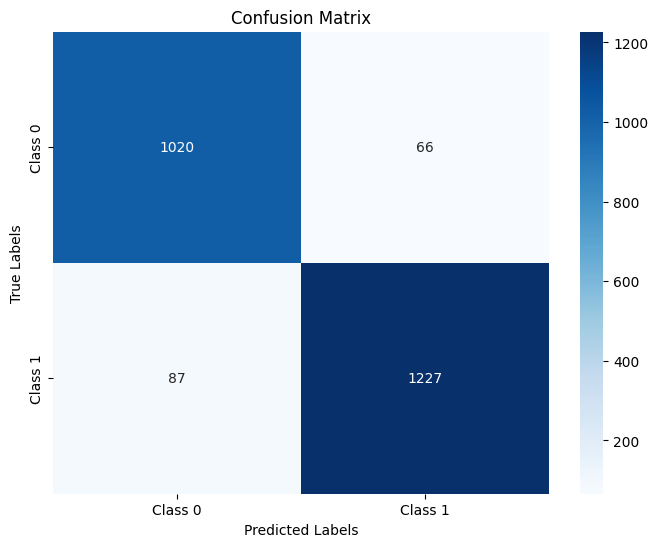

Class Distribution in Test Set:
Class 0: 1086 samples
Class 1: 1314 samples


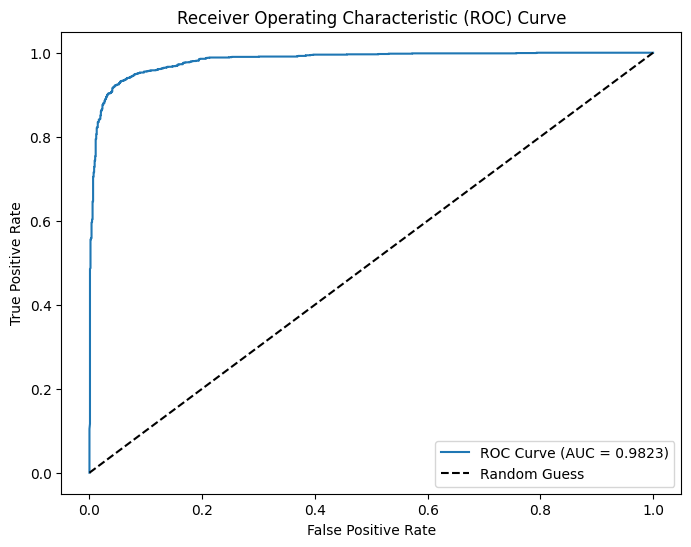

In [ ]:
# Assuming y_test_bert and predictions.predictions are defined
# Convert tensors to NumPy arrays
y_test_bert_np = y_test_bert.cpu().numpy()  # Ground truth labels
predicted_labels_np = predicted_labels.cpu().numpy()  # Predicted class labels

# Confusion Matrix
cm = confusion_matrix(y_test_bert_np, predicted_labels_np)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Class Distribution in Test Set
class_distribution = {label: count for label, count in zip(*np.unique(y_test_bert_np, return_counts=True))}

# Display Class Distribution
print("Class Distribution in Test Set:")
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

# ROC-AUC and ROC Curve
y_test_bert_prob = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].cpu().numpy()  # Probability for Class 1
fpr, tpr, thresholds = roc_curve(y_test_bert_np, y_test_bert_prob)
roc_auc = roc_auc_score(y_test_bert_np, y_test_bert_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
